# Lung Cancer

## Index <a id="Index"></a>

1. [Introduction](#Introduction)
    1. [Project Overview](#Project-Overview)
    2. [Objectives](#Objectives)
    3. [Our Approach](#Our-Approach)
2. [Imports](#Imports)
3. [Obtaining the features](#Obtain-the-features)
4. [Data Clean-up](#Data-Clean-up)
5. [Data Analysis](#Data-Analysis)
6. [Classification](#Classification)
    1. [Decision Tree Classifier](#Decision-Tree-Classifier)
    2. [Random Forest Classifier](#Random-Forest-Classifier)
    4. [K Neighbors Classifier](#Knn)
    5. [Support Vector Machines](#Support-Vector-Machines)
    6. [Naive Bayes](#Naive-Bayes)
        1. [GaussianNB](#GaussianNB)
        2. [MultinomialNB](#MultinomialNB)
7. [Conclusion](#Conclusion)

## Introduction <a id="Introduction"></a>
[Back to index](#Index)

### Project Overview <a id="Project-Overview"></a>

In this project our goal is to develop a  Data Science-based solution to solve the problem of Lung Cancer
Classification using Computerized Tomography (CT) Data. Our initial data comes from images of CT scans from 1010 patients and we intend to extract its features from the images.

### Objectives <a id="Objectives"></a>

Our goal is to develop a robust and accurate classification system that can distinguish between benign and malignant nodules, which could assist healthcare professionals in making informed decisions, as well as improve our programming skills and machine learning and data science knowledge.

### Our Approach <a id="Our-Approach"></a>

The first step is to extract the features from the CT images and colect them in a csv.
Next we will evaluate the need for cleaning the data and preprocess it.
After that, the final step is to develop machine learning models and avaluate its performance.

## Imports
[Back to index](#Index)

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

### Obtaining the features <a id="Obtain-the-features"></a>
[Back to index](#Index)

Running the python script:

`python get_features.py`
 
we are going to acess the information in the pylidc library and extract its features and calculating the mean or mode for all annotators as well as extracting all radiomics features

%run get_features.py

To run the script change the cell above from markdown to code and run it.

If you interrupt the cell above without it finishing you need to restart your kerner to prevent: 

`PendingRollbackError: Can't reconnect until invalid transaction is rolled back.  Please rollback() fully before proceeding (Background on this error at: https://sqlalche.me/e/20/8s2b)`





## Data Clean-up <a id="Data-Clean-up"></a>
[Back to index](#Index)

Now we are going to clean the data

For starters let's read the csv and print the features dataset

In [2]:
df = pd.read_csv('radiomic_features.csv')
df

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,Patient_ID,Nodule_ID,subtlety,internalStructure,sphericity,margin,lobulation,spiculation,texture,malignancy
0,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},966db6c8d814983bbfe7125907b2ae5008c7994e,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0078,Nodule_1,4,1,4,4,2,2,5,3.75
1,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d750f93365c734f6f1972e806b046bb1a203f47f,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0078,Nodule_2,5,1,4,2,4,1,5,3.75
2,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},58d9ee5073ad7215556c1e295a67e9204a623b2d,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0078,Nodule_3,4,1,5,5,1,1,5,1.00
3,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},312913e3e22bc6f2e6cffc8abd1120da5fa413fd,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0078,Nodule_4,5,1,4,2,4,3,5,4.25
4,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},08706c40effcb9f7489dc9ce0139a265b8dc6048,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0069,Nodule_5,3,1,5,5,5,5,5,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},db18dcbfdf1ebd1c1390db9dd1fbfd85cce4724b,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0639,Nodule_2647,4,1,4,4,2,2,5,4.00
2647,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},fe63df501e056c7f875ab771151194481c70a0b1,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0639,Nodule_2648,1,1,4,1,1,1,1,3.50
2648,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},e25d0da08cbc45ea3587c9426cc102940176a4de,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0638,Nodule_2649,2,1,4,3,1,1,5,3.50
2649,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},5888efc13966913742433819826d00f4d79f0c24,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0638,Nodule_2650,5,1,4,5,1,1,5,2.00


Next, we are going to check if there are any null values

In [3]:
df.isna().sum()

diagnostics_Versions_PyRadiomics    0
diagnostics_Versions_Numpy          0
diagnostics_Versions_SimpleITK      0
diagnostics_Versions_PyWavelet      0
diagnostics_Versions_Python         0
                                   ..
margin                              0
lobulation                          0
spiculation                         0
texture                             0
malignancy                          0
Length: 139, dtype: int64

Since there are no null values we don't need to perform any null value handling

Now we are going to check if there are columns with only one value

In [4]:
df.nunique().tolist()

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 2651,
 1,
 1,
 1339,
 2334,
 1,
 1,
 2651,
 1,
 1339,
 1856,
 951,
 6,
 2651,
 2651,
 2651,
 2570,
 2570,
 2651,
 325,
 394,
 314,
 658,
 2347,
 2651,
 2650,
 2650,
 2650,
 951,
 1,
 1,
 951,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 951,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2647,
 2483,
 2536,
 2648,
 951,
 1,
 1,
 2641,
 2641,
 2641,
 1,
 2650,
 2650,
 2650,
 1668,
 1,
 1,
 1,
 2651,
 2651,
 2651,
 1,
 2651,
 2651,
 2651,
 2546,
 2651,
 2651,
 2651,
 2651,
 6,
 1,
 1,
 1,
 962,
 962,
 962,
 1,
 7,
 9,
 962,
 962,
 962,
 9,
 951,
 48,
 1,
 1,
 1,
 1,
 1,
 875,
 2651,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 35]

A lot of columns have only one value, and we can conclude that they will not be helpful at predicting the label. So, we are going to drop them.

In [5]:
unique_value_counts = df.nunique()
columns_with_single_unique_value = unique_value_counts[unique_value_counts == 1].index
df.drop(columns=columns_with_single_unique_value,inplace=True)

Let's see the updated dataset

In [6]:
df

,diagnostics_Image-original_Hash,diagnostics_Image-original_Size,diagnostics_Image-original_Mean,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Size,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_CenterOfMass,...,Patient_ID,Nodule_ID,subtlety,internalStructure,sphericity,margin,lobulation,spiculation,texture,malignancy
0,966db6c8d814983bbfe7125907b2ae5008c7994e,"(6, 84, 74)",0.051024,916fa76fc2ef7083acad0f0a5b4ae605e176a590,"(6, 84, 74)","(0, 26, 21, 6, 33, 31)",1903,1,"(2.606936416184971, 45.86600105097215, 38.7924...","(2.606936416184971, 45.86600105097215, 38.7924...",...,LIDC-IDRI-0078,Nodule_1,4,1,4,4,2,2,5,3.75
1,d750f93365c734f6f1972e806b046bb1a203f47f,"(6, 67, 80)",0.054136,21bb257f501d97fdac963a3eed3bc79763808d45,"(6, 67, 80)","(0, 21, 27, 6, 25, 31)",1741,1,"(2.090178058587019, 31.88684663986215, 43.5117...","(2.090178058587019, 31.88684663986215, 43.5117...",...,LIDC-IDRI-0078,Nodule_2,5,1,4,2,4,1,5,3.75
2,58d9ee5073ad7215556c1e295a67e9204a623b2d,"(2, 47, 48)",0.007535,69eb0f6ec04ddf064cd30ecaaab2da630ee49849,"(2, 47, 48)","(0, 21, 21, 2, 5, 6)",34,1,"(0.2647058823529412, 23.323529411764707, 23.67...","(0.2647058823529412, 23.323529411764707, 23.67...",...,LIDC-IDRI-0078,Nodule_3,4,1,5,5,1,1,5,1.00
3,312913e3e22bc6f2e6cffc8abd1120da5fa413fd,"(8, 80, 90)",0.063299,5a014e3c44e80c29336a84747194b1bf20aa48ef,"(8, 80, 90)","(0, 23, 24, 8, 35, 43)",3646,3,"(3.593801426220516, 37.13055403181569, 44.0181...","(3.593801426220516, 37.13055403181569, 44.0181...",...,LIDC-IDRI-0078,Nodule_4,5,1,4,2,4,3,5,4.25
4,08706c40effcb9f7489dc9ce0139a265b8dc6048,"(9, 59, 66)",0.014866,0e09298de81c2adef7164a13f222f85b3079fe33,"(9, 59, 66)","(0, 25, 22, 8, 12, 15)",521,1,"(4.113243761996161, 30.23608445297505, 29.5854...","(4.113243761996161, 30.23608445297505, 29.5854...",...,LIDC-IDRI-0069,Nodule_5,3,1,5,5,5,5,5,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646,db18dcbfdf1ebd1c1390db9dd1fbfd85cce4724b,"(10, 58, 55)",0.010188,963a7955ee5420a87b6a515b492cca8fc89e3993,"(10, 58, 55)","(1, 23, 24, 9, 13, 10)",325,1,"(5.9107692307692306, 28.12923076923077, 27.815...","(5.9107692307692306, 28.12923076923077, 27.815...",...,LIDC-IDRI-0639,Nodule_2647,4,1,4,4,2,2,5,4.00
2647,fe63df501e056c7f875ab771151194481c70a0b1,"(11, 54, 55)",0.019069,a7ae2e2729f721b44722634bb7c16d378fdedc2b,"(11, 54, 55)","(0, 21, 21, 11, 12, 13)",623,1,"(5.425361155698234, 25.696629213483146, 27.226...","(5.425361155698234, 25.696629213483146, 27.226...",...,LIDC-IDRI-0639,Nodule_2648,1,1,4,1,1,1,1,3.50
2648,e25d0da08cbc45ea3587c9426cc102940176a4de,"(3, 57, 53)",0.020854,5ee5cad2f9071e80d65abc9086faefb7e2ada532,"(3, 57, 53)","(0, 21, 21, 3, 15, 11)",189,1,"(0.7883597883597884, 27.978835978835978, 25.87...","(0.7883597883597884, 27.978835978835978, 25.87...",...,LIDC-IDRI-0638,Nodule_2649,2,1,4,3,1,1,5,3.50
2649,5888efc13966913742433819826d00f4d79f0c24,"(4, 50, 52)",0.007404,edb26895286ee1ebb94f0dd324b07f3be9624c33,"(4, 50, 52)","(0, 21, 22, 4, 8, 8)",77,1,"(1.6103896103896105, 24.662337662337663, 25.79...","(1.6103896103896105, 24.662337662337663, 25.79...",...,LIDC-IDRI-0638,Nodule_2650,5,1,4,5,1,1,5,2.00


As we can see, in the dataset some columns have Ids and tuples with numbers and since there is no point in label encoding them since these columns don´t really represent features of the nodules and just information about the general images or masks. So, we will drop those columns, remaining just numerical data.

In [7]:
df = df.select_dtypes(include=[int, float])
df

,diagnostics_Image-original_Mean,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,...,original_glszm_ZonePercentage,original_glszm_ZoneVariance,subtlety,internalStructure,sphericity,margin,lobulation,spiculation,texture,malignancy
0,0.051024,1903,1,0.848594,0.219031,5.542891,25.306411,24.020824,39.051248,26.000000,...,0.000525,0.000000e+00,4,1,4,4,2,2,5,3.75
1,0.054136,1741,1,0.845360,0.215045,5.209030,24.222923,30.016662,31.064449,23.021729,...,0.000574,0.000000e+00,5,1,4,2,4,1,5,3.75
2,0.007535,34,1,0.879310,0.289526,1.632763,5.639429,6.000000,6.324555,5.099020,...,0.029412,0.000000e+00,4,1,5,5,1,1,5,1.00
3,0.063299,3646,3,0.956858,0.216692,6.435946,29.700850,37.054015,43.566042,35.227830,...,0.000823,2.949211e+06,5,1,4,2,4,3,5,4.25
4,0.014866,521,1,0.779886,0.595806,7.374952,12.378110,15.524175,14.142136,12.041595,...,0.001919,0.000000e+00,3,1,5,5,5,5,5,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646,0.010188,325,1,0.793847,0.375133,4.534490,12.087678,12.806248,11.401754,13.928388,...,0.003077,0.000000e+00,4,1,4,4,2,2,5,4.00
2647,0.019069,623,1,0.754255,0.687954,8.589183,12.485120,14.422205,14.317821,12.649111,...,0.001605,0.000000e+00,1,1,4,1,1,1,1,3.50
2648,0.020854,189,1,0.564212,0.185778,2.586515,13.922612,11.045361,14.866069,12.165525,...,0.005291,0.000000e+00,2,1,4,3,1,1,5,3.50
2649,0.007404,77,1,0.453474,0.247844,2.471175,9.970706,7.280110,7.211103,7.615773,...,0.012987,0.000000e+00,5,1,4,5,1,1,5,2.00


Since we applied the mean to all of the values in the annotations for each nodule they are in between [1,5]. We are going to check the count of each value in the malignancy column.

In [8]:
df["malignancy"].value_counts()

malignancy
3.000000    641
2.000000    417
1.000000    272
2.500000    228
2.666667    130
4.000000    127
3.500000    116
2.750000    111
3.250000     95
2.333333     65
3.750000     54
2.250000     46
3.333333     45
1.500000     45
4.250000     42
4.500000     41
5.000000     37
3.666667     33
4.750000     23
1.666667     18
1.750000     17
4.333333     13
1.250000     10
4.666667     10
1.333333      5
2.600000      1
3.600000      1
3.166667      1
4.166667      1
4.200000      1
3.800000      1
3.714286      1
3.428571      1
4.285714      1
3.400000      1
Name: count, dtype: int64

As we can see, there are a lot of values with 3, so we are going to drop them since they are not useful for our classification.
The rest of the values are going to be converted to 0 or 1, where 0 is benign and 1 is malignant.

In [9]:
df = df[df['malignancy'] != 3]

df.loc[:, "malignancy"] = df["malignancy"].apply(lambda x: 1 if x > 3 else 0)

Let's see the updated malignancy column

In [10]:
df["malignancy"].value_counts()

malignancy
0.0    1365
1.0     645
Name: count, dtype: int64

As shown above, the labels are not balanced, so we are going to use oversampling to balance them.

In [11]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
df, _ = smote.fit_resample(df, df['malignancy'])

Now the values should be equally distributed

In [12]:
df["malignancy"].value_counts()


malignancy
1.0    1365
0.0    1365
Name: count, dtype: int64

Afterwards we need to normalize the columns using Min-Max scaling due to not having scale consistency

In [13]:
df = (df - df.min()) / (df.max() - df.min())

Since the column names are very long and not concise nor clear we will simplify them to make them more understandable.

In [14]:
new_column_names = [
    'Mean',
    'VoxelNum',
    'VolumeNum',
    'Elongation',
    'Flatness',
    'LeastAxisLength',
    'MajorAxisLength',
    'DiameterColumn',
    'DiameterRow',
    'DiameterSlice',
    'Max3DDiameter',
    'MeshVolume',
    'MinorAxisLength',
    'Sphericity',
    'SurfaceArea',
    'SurfaceVolRatio',
    'VoxelVol',
    'Energy',
    'TotalEnergy',
    'DiffEntropy',
    'JointEntropy',
    'SumEntropy',
    'DependEntropy',
    'DependNonUniformity',
    'DependNonUniformityNorm',
    'DependVariance',
    'GrayLevelNonUniformity',
    'LargeDependEmphasis',
    'LargeDependHighGLEmphasis',
    'LargeDependLowGLEmphasis',
    'SmallDependEmphasis',
    'SmallDependHighGLEmphasis',
    'SmallDependLowGLEmphasis',
    'GLNonUniformity',
    'LongRunEmphasis',
    'LongRunHighGLEmphasis',
    'LongRunLowGLEmphasis',
    'RunEntropy',
    'RunLengthNonUniformity',
    'RunLenNonUniformityNorm',
    'RunPercentage',
    'RunVariance',
    'ShortRunEmphasis',
    'ShortRunHighGLEmphasis',
    'ShortRunLowGLEmphasis',
    'GLNonUniformity_GLSZM',
    'LargeAreaEmphasis',
    'LargeAreaHighGLEmphasis',
    'LargeAreaLowGLEmphasis',
    'SizeZoneNonUniformity',
    'SizeZoneNonUniformityNorm',
    'SmallAreaEmphasis',
    'SmallAreaHighGLEmphasis',
    'SmallAreaLowGLEmphasis',
    'ZoneEntropy',
    'ZonePercentage',
    'ZoneVariance',
    'Subtlety',
    'InternalStructure',
    'Sphericity',
    'Margin',
    'Lobulation',
    'Spiculation',
    'Texture',
    'Malignancy'
]
df.columns = new_column_names

Now let's take a look at the updated dataset

In [15]:
df

,Mean,VoxelNum,VolumeNum,Elongation,Flatness,LeastAxisLength,MajorAxisLength,DiameterColumn,DiameterRow,DiameterSlice,...,ZonePercentage,ZoneVariance,Subtlety,InternalStructure,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy
0,0.398388,0.041876,0.000,0.800345,0.244418,0.156384,0.363943,0.359994,0.519872,0.293561,...,0.002402,0.000000,0.75,0.0,0.75,0.75,0.25,0.25,1.00,1.0
1,0.423089,0.038302,0.000,0.795950,0.239970,0.146965,0.346630,0.462676,0.404700,0.256770,...,0.002647,0.000000,1.00,0.0,0.75,0.25,0.75,0.00,1.00,1.0
2,0.053140,0.000640,0.000,0.842097,0.323084,0.046066,0.049688,0.051377,0.047941,0.035367,...,0.146866,0.000000,0.75,0.0,1.00,1.00,0.00,0.00,1.00,0.0
3,0.495832,0.080333,0.125,0.947505,0.241808,0.181580,0.434161,0.583195,0.584977,0.407555,...,0.003889,0.026006,1.00,0.0,0.75,0.25,0.75,0.50,1.00,1.0
4,0.111337,0.011385,0.000,0.706953,0.664863,0.208073,0.157364,0.214484,0.160674,0.121130,...,0.009373,0.000000,0.50,0.0,1.00,1.00,1.00,1.00,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,0.146078,0.003618,0.000,0.500024,0.258786,0.078401,0.151917,0.145897,0.138285,0.087722,...,0.029342,0.000000,0.75,0.0,0.50,1.00,0.00,0.00,1.00,1.0
2726,0.274997,0.035037,0.000,0.429916,0.235521,0.170402,0.416814,0.450243,0.534841,0.330323,...,0.002912,0.000000,1.00,0.0,0.25,0.75,0.00,0.25,1.00,1.0
2727,0.346362,0.054607,0.000,0.305325,0.172922,0.164180,0.584979,0.455872,0.515510,0.401251,...,0.001791,0.000000,1.00,0.0,0.25,0.50,0.00,0.00,1.00,1.0
2728,0.454973,0.074971,0.000,0.732047,0.286005,0.212082,0.436462,0.522382,0.469772,0.352919,...,0.001243,0.000000,1.00,0.0,0.75,0.50,0.00,0.75,0.75,1.0


## Data Analysis <a id="Data-Analysis"></a>
[Back to index](#Index)

Rigth now we are going to analyze the data and see if there are any correlations between the features and the label in order to have better performance in the our classification models.

### Correlation Analysis

In [16]:
df.select_dtypes(include=['object'])
numeric_columns = df.select_dtypes(include=['object'])
correlation_matrix = numeric_columns.corr()


This code provides insights into the distribution and characteristics of these diagnostic values, wich may represent various image and mask features 

In [17]:
# Diagnostics Columns
mean_image = df['Mean']
voxel_num = df['VoxelNum']
volume_num = df['VolumeNum']

# Summary statistics
print(mean_image.describe())
print(voxel_num.describe())
print(volume_num.describe())

count    2730.000000
mean        0.178988
std         0.144535
min         0.000000
25%         0.075987
50%         0.127464
75%         0.234362
max         1.000000
Name: Mean, dtype: float64
count    2730.000000
mean        0.027263
std         0.058803
min         0.000000
25%         0.002008
50%         0.005571
75%         0.021418
max         1.000000
Name: VoxelNum, dtype: float64
count    2730.000000
mean        0.002266
std         0.023790
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: VolumeNum, dtype: float64


This code segment focuses on a set of columns related to shape features of tumors

        Elongation     Flatness  LeastAxisLength  MajorAxisLength  \
count  2730.000000  2730.000000      2730.000000      2730.000000   
mean      0.682212     0.416915         0.147710         0.198909   
std       0.170896     0.186999         0.109305         0.154742   
min       0.000000     0.000000         0.000000         0.000000   
25%       0.580849     0.280337         0.077636         0.087025   
50%       0.705617     0.382837         0.117156         0.143175   
75%       0.809835     0.540705         0.176403         0.260442   
max       1.000000     1.000000         1.000000         1.000000   

       DiameterColumn  DiameterRow  DiameterSlice  Max3DDiameter   MeshVolume  \
count     2730.000000  2730.000000    2730.000000    2730.000000  2730.000000   
mean         0.210255     0.202969       0.159655       0.190111     0.027121   
std          0.176679     0.165346       0.128621       0.155726     0.058844   
min          0.000000     0.000000       0.000000     

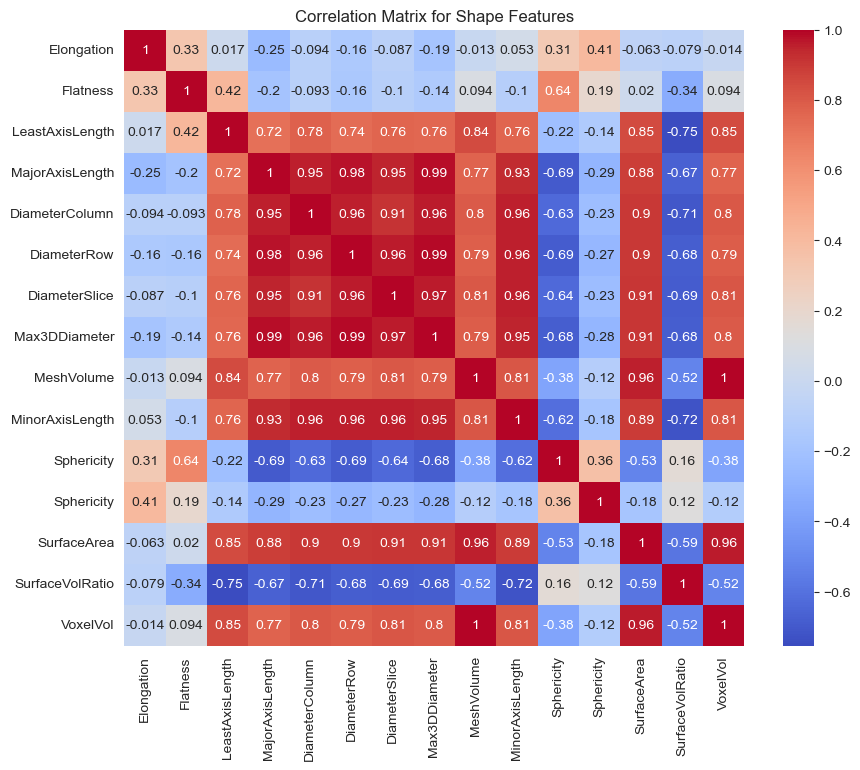

In [18]:
# shape features
shape_columns = [
    'Elongation',
    'Flatness',
    'LeastAxisLength',
    'MajorAxisLength',
    'DiameterColumn',
    'DiameterRow',
    'DiameterSlice',
    'Max3DDiameter',
    'MeshVolume',
    'MinorAxisLength',
    'Sphericity',
    'SurfaceArea',
    'SurfaceVolRatio',
    'VoxelVol',
]

# Summary statistics for shape features
shape_summary = df[shape_columns].describe()
print(shape_summary)

# Correlation analysis for shape features
shape_correlation_matrix = df[shape_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(shape_correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for Shape Features")
plt.show()

In the correlation matrix displayed above, we observe a rich network of interconnections among various features. Notably, a prominent 5x5 square region stands out, marked in pink, indicating a substantial degree of correlation between the enclosed features. In practical terms, this means that when one feature experiences an increase, a corresponding increase in the other is highly likely, signifying a strong positive correlation.

       GLNonUniformity_GLSZM  LargeAreaEmphasis  LargeAreaHighGLEmphasis  \
count            2730.000000        2730.000000              2730.000000   
mean                0.002474           0.014643                 0.014643   
std                 0.024420           0.063768                 0.063768   
min                 0.000000           0.000000                 0.000000   
25%                 0.000000           0.000019                 0.000019   
50%                 0.000000           0.000134                 0.000134   
75%                 0.000000           0.001926                 0.001926   
max                 1.000000           1.000000                 1.000000   

       LargeAreaLowGLEmphasis  SizeZoneNonUniformity  \
count             2730.000000            2730.000000   
mean                 0.014643               0.001685   
std                  0.063768               0.028730   
min                  0.000000               0.000000   
25%                  0.000019      

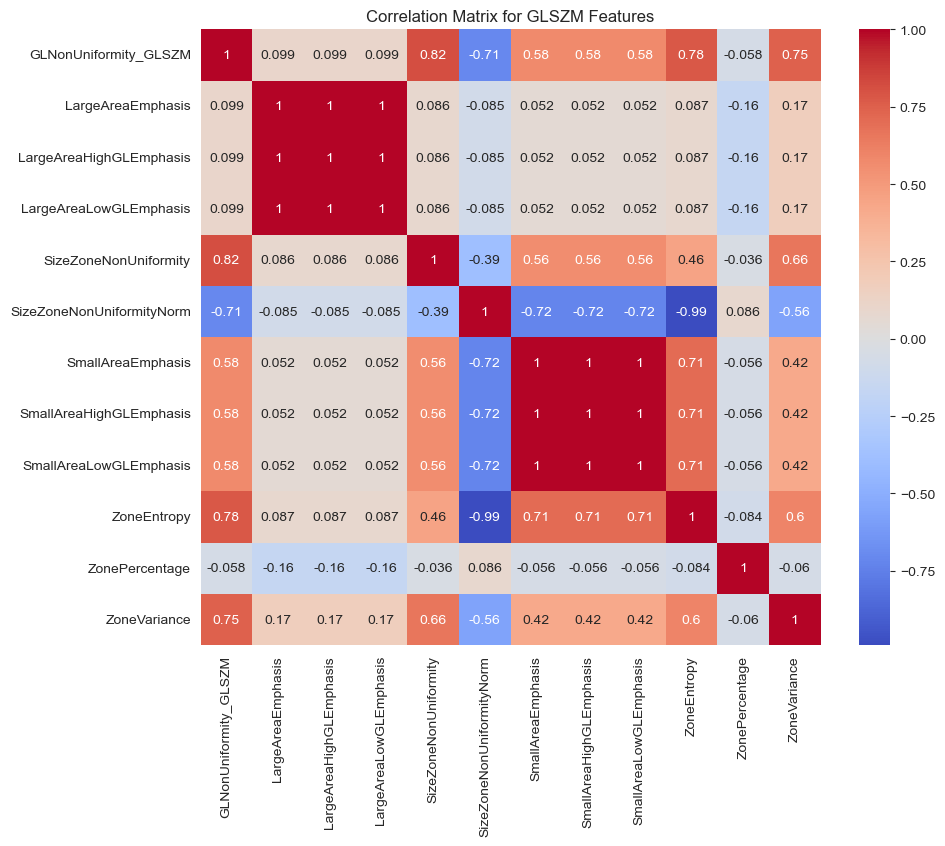

In [19]:
# GLSZM Features
glszm_columns = [
    'GLNonUniformity_GLSZM',
    'LargeAreaEmphasis',
    'LargeAreaHighGLEmphasis',
    'LargeAreaLowGLEmphasis',
    'SizeZoneNonUniformity',
    'SizeZoneNonUniformityNorm',
    'SmallAreaEmphasis',
    'SmallAreaHighGLEmphasis',
    'SmallAreaLowGLEmphasis',
    'ZoneEntropy',
    'ZonePercentage',
    'ZoneVariance',
]

# Summary statistics for GLSZM features
glszm_summary = df[glszm_columns].describe()
print(glszm_summary)

# Correlation analysis for GLSZM features
glszm_correlation_matrix = df[glszm_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(glszm_correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix for GLSZM Features")
plt.show()

The Gray-Level Size Zone Matrix (GLSZM) is a quantitative image analysis technique used to characterize the spatial distribution of zones of specific gray levels within an image. It provides information about the frequency and sizes of these zones, offering insights into the textural properties of the image. In simpler terms, the GLSZM helps us understand how different shades of gray are arranged in the image and how large or small these regions of specific gray levels are.

In our analysis, we've observed that there are a lot of features that have a strong correlation (value = 1); with this information we conclude that a lor of the features are redundant and in the furture could be removed. However in this project we are going to keep all the features seen above and see how they perform in our classification models. In theory, our conclusion will be that they not affect the performance of the models.


Rigth now we are going to analyze the correlation between the features and the malignancy label.

Index(['Mean', 'VoxelNum', 'LeastAxisLength', 'MajorAxisLength',
       'DiameterColumn', 'DiameterRow', 'DiameterSlice', 'Max3DDiameter',
       'MeshVolume', 'MinorAxisLength', 'Sphericity', 'SurfaceArea',
       'SurfaceVolRatio', 'VoxelVol', 'Energy', 'TotalEnergy',
       'DependNonUniformityNorm', 'DependVariance', 'GrayLevelNonUniformity',
       'LargeDependEmphasis', 'LargeDependHighGLEmphasis',
       'LargeDependLowGLEmphasis', 'SmallDependEmphasis',
       'SmallDependHighGLEmphasis', 'SmallDependLowGLEmphasis',
       'GLNonUniformity', 'LongRunEmphasis', 'LongRunHighGLEmphasis',
       'LongRunLowGLEmphasis', 'RunEntropy', 'RunLengthNonUniformity',
       'RunLenNonUniformityNorm', 'RunPercentage', 'RunVariance',
       'ShortRunEmphasis', 'ShortRunHighGLEmphasis', 'ShortRunLowGLEmphasis',
       'ZonePercentage', 'Subtlety', 'Malignancy'],
      dtype='object')


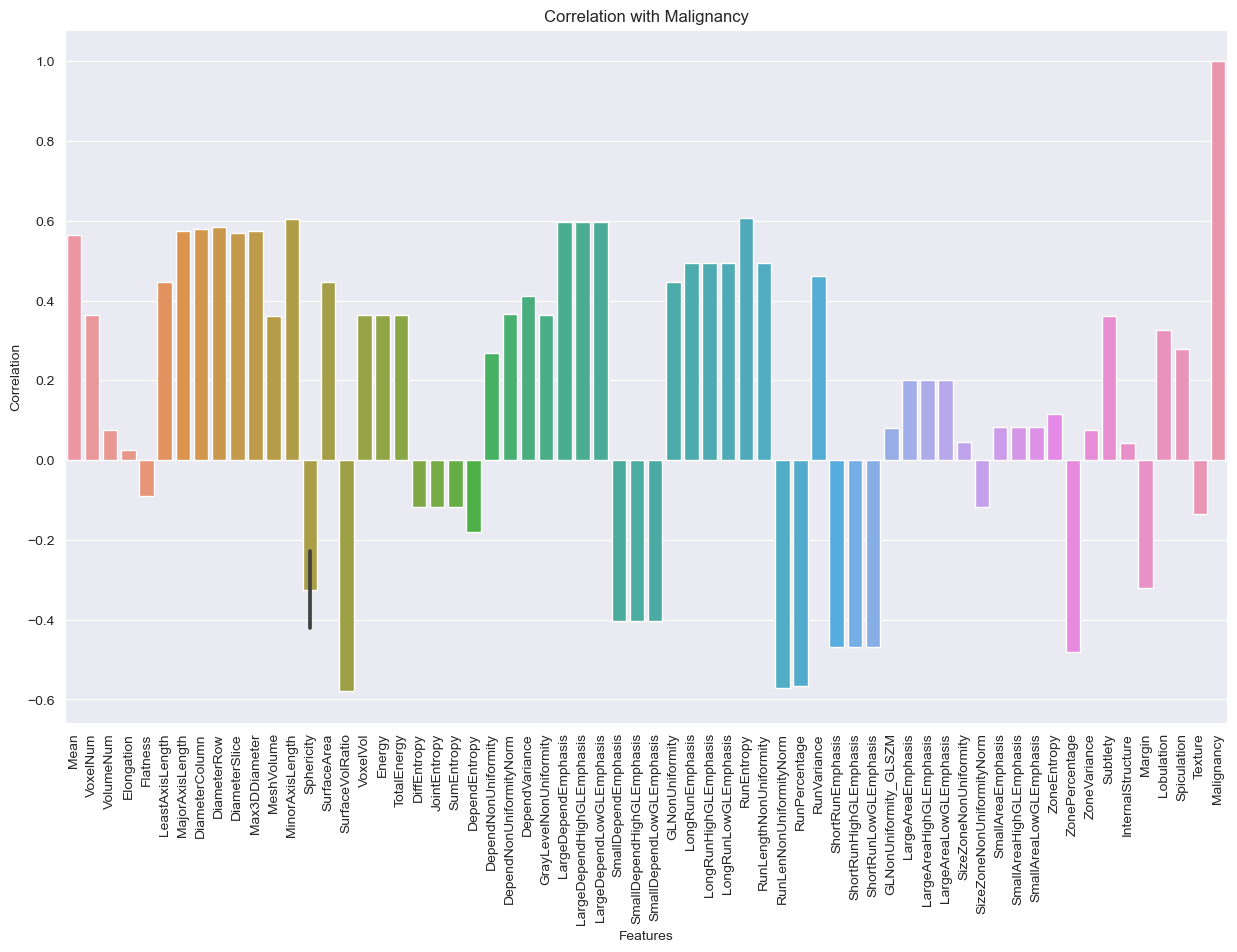

In [20]:
correlation_threshold = 0.35

correlation_with_malignancy = df.corr()['Malignancy']
high_correlation_features = correlation_with_malignancy[correlation_with_malignancy.abs() >= correlation_threshold].index
print(high_correlation_features)

# Create a bar plot to visualize correlations
plt.figure(figsize=(15, 9))
sns.barplot(x=correlation_with_malignancy.index, y=correlation_with_malignancy)
plt.xticks(rotation=90)
plt.title('Correlation with Malignancy')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.show()

As we can see, there are some features that have a high correlation with the label, so we are going to use them in our classification models to see how it performs

## Classification <a id="Classification"></a>
[Back to index](#Index)

We created some functions to help us test every model.

In [21]:
def heatmap(test,pred):
    cm = confusion_matrix(test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [22]:
def testing(test,pred):
    accuracy = accuracy_score(test, pred)
    report = classification_report(test, pred, zero_division=1)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    heatmap(test,pred)

In [23]:
def cross_validation(model, a, b, cv=10):
    scores = cross_val_score(model, a, b, cv=cv, scoring='accuracy')
    plt.figure(figsize=(8, 4))  # Create a separate figure
    plt.hist(scores)
    plt.title('Cross Validation average score: {}'.format(np.average(scores)))
    plt.show()
    return np.average(scores)  # Return the average accuracy score

In [57]:
def average_score(model, a, b):
    model_accuracies = []
    model_precisions = []
    for repetition in range(1):
        x_train, x_test, Y_train, Y_test = train_test_split(a, b, test_size=0.3)

        model.fit(x_train, Y_train)
        Y_pred = model.predict(x_test)

        accuracy = accuracy_score(Y_test, Y_pred)
        precision = precision_score(Y_test, Y_pred)

        model_accuracies.append(accuracy)
        model_precisions.append(precision)
        

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Create two subplots

    ax1.hist(model_accuracies, color='blue', alpha=0.7, label='Accuracy')
    ax1.set_title('Accuracy average score: {}'.format(np.average(model_accuracies)))

    ax2.hist(model_precisions, color='green', alpha=0.7, label='Precision')
    ax2.set_title('Precision average score: {}'.format(np.average(model_precisions)))

    plt.show()

    average_accuracy = np.average(model_accuracies)
    average_precision = np.average(model_precisions)

    return average_accuracy, average_precision


In [25]:
def importance(model, a):
    impor=pd.DataFrame({'feature':a.columns,
                             'importance':np.round(model.feature_importances_, 3)})
    impor.sort_values('importance',ascending=False, inplace =True)
    return impor

After noticing that there are higher correlation features than other, we did a test with the Random Forest Classifier: we tried only using the features with 0.5 correlation.

In [26]:
testing_df = df[high_correlation_features]
testing_X = df.iloc[:, :-1]
testing_y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(testing_X, testing_y, test_size=0.3)

In [27]:
testing_rf_classifier = RandomForestClassifier(criterion="entropy", max_depth=30, min_samples_leaf=2, n_estimators=200)
testing_rf_classifier.fit(X_train, y_train)
y_pred = testing_rf_classifier.predict(X_test)

Accuracy: 0.8681318681318682
Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.85      0.87       421
         1.0       0.85      0.88      0.87       398

    accuracy                           0.87       819
   macro avg       0.87      0.87      0.87       819
weighted avg       0.87      0.87      0.87       819


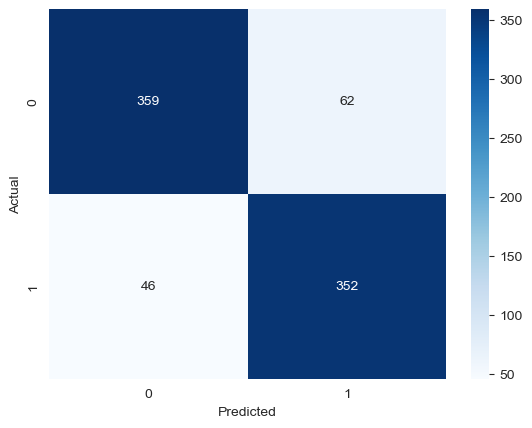

In [28]:
testing(y_test, y_pred)

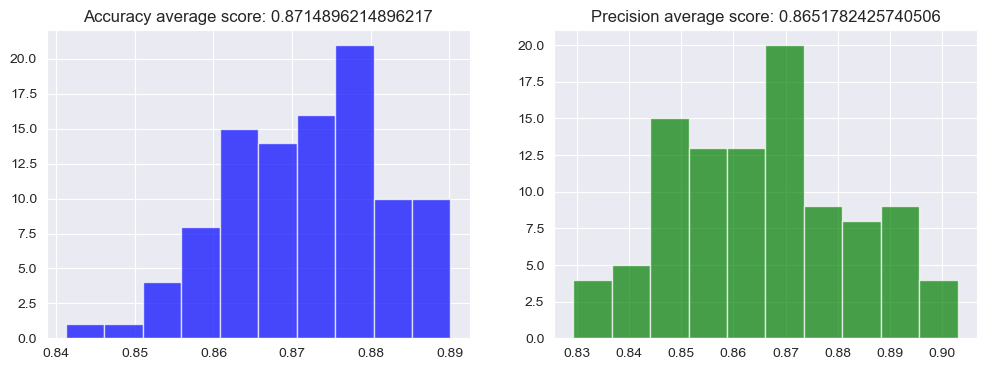

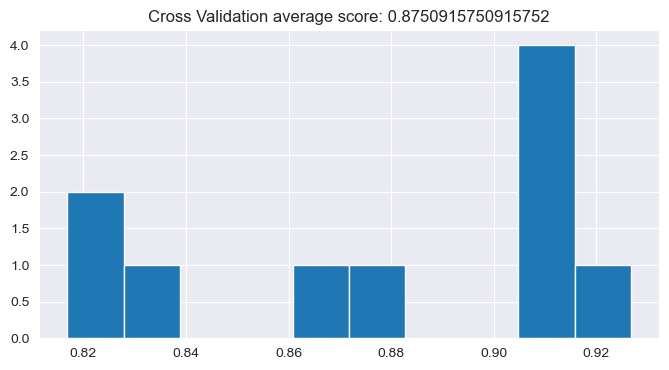

0.8750915750915752

In [29]:
average_score(testing_rf_classifier, testing_X, testing_y)
cross_validation(testing_rf_classifier, testing_X, testing_y)

After noticing that diference in the percentages isn't significant, we decided to keep all the features.
 
We tried with 0.35 and 0.5 correlation values and the results were the same.

Now we are going to test the models and see which one performs better. With each model we are going to test its accuracy, precision and cross validation score. While doint it, we are going to save each models test and then compare it after, to see which one performs better.

For the models hyper-paramenters we used the default ones first. Then after completing all the code for all the models we did some parameter tuning and we verified that the change was almost not significant, still, we used the best parameters for each model.
 
The code for the parameter tuning is in the end of the notebook.

On the models that permit it, we show the importance of each feature.

In [30]:
model_scores = []
X = df.iloc[:, :-1]  # Features (all columns except the last one)
y = df.iloc[:, -1]   # Target (the last column)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Decision Tree Classifier <a id="Decision-Tree-Classifier"></a>

In [31]:
tree=DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=1, min_samples_split=10) 
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

Accuracy: 0.7973137973137974
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.78      0.79       407
         1.0       0.79      0.82      0.80       412

    accuracy                           0.80       819
   macro avg       0.80      0.80      0.80       819
weighted avg       0.80      0.80      0.80       819


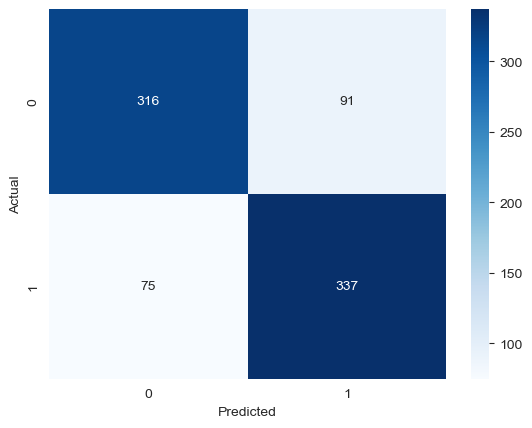

In [32]:
testing(y_test,y_pred)

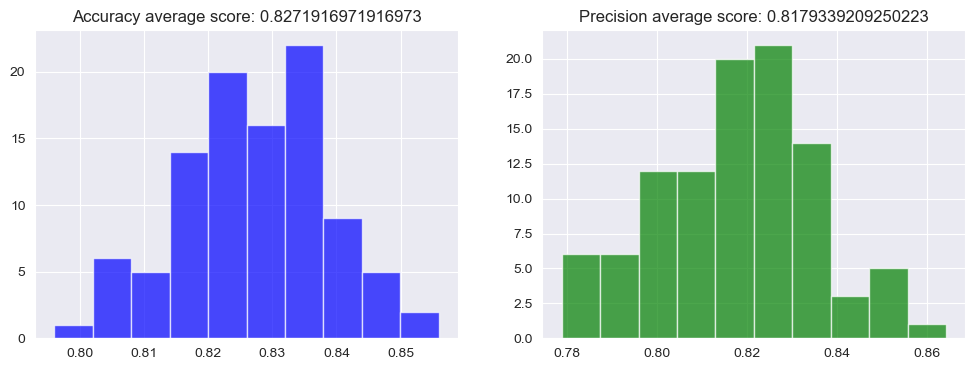

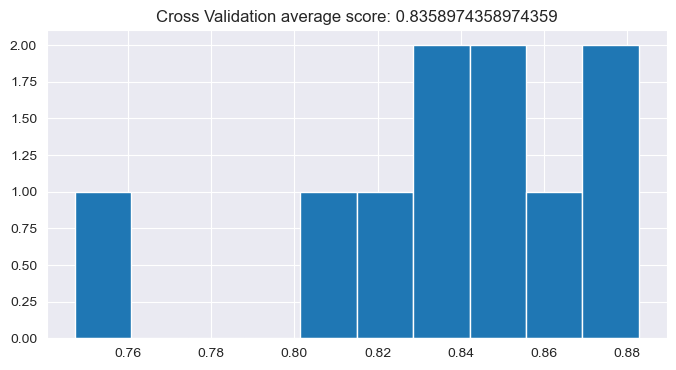

In [33]:
tree_accuracy,tree_precision = average_score(tree,X,y)
tree_cross = cross_validation(tree,X,y)
model_scores.append(("Decision Tree Classifier",tree_accuracy,tree_precision,tree_cross))

In [34]:
importance(tree,X_train)

,feature,importance
12,MinorAxisLength,0.628
60,Margin,0.040
25,DependVariance,0.036
0,Mean,0.022
57,Subtlety,0.019
...,...,...
18,TotalEnergy,0.000
17,Energy,0.000
14,SurfaceArea,0.000
13,Sphericity,0.000


### Random Forest Classifier <a id="Random-Forest-Classifier"></a>

In [35]:
rf_classifier = RandomForestClassifier(criterion="entropy", max_depth=30, min_samples_leaf=2, n_estimators=200)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

Accuracy: 0.8778998778998779
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       407
         1.0       0.88      0.88      0.88       412

    accuracy                           0.88       819
   macro avg       0.88      0.88      0.88       819
weighted avg       0.88      0.88      0.88       819


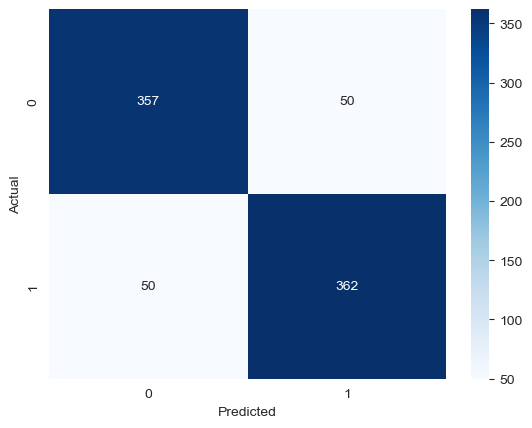

In [36]:
testing(y_test,y_pred)

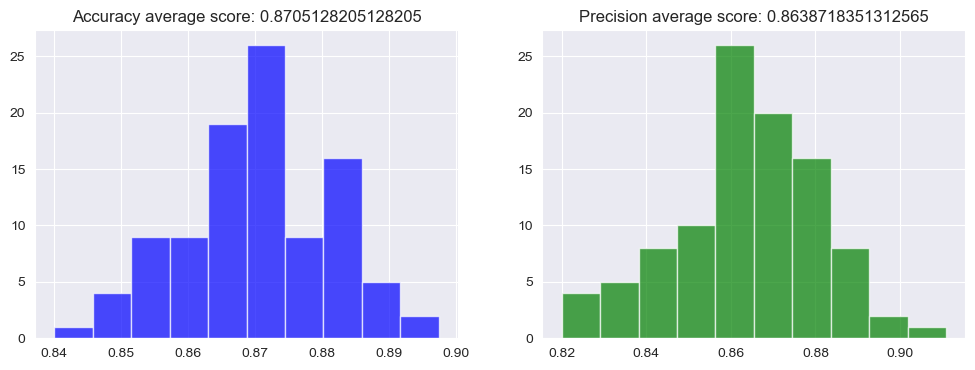

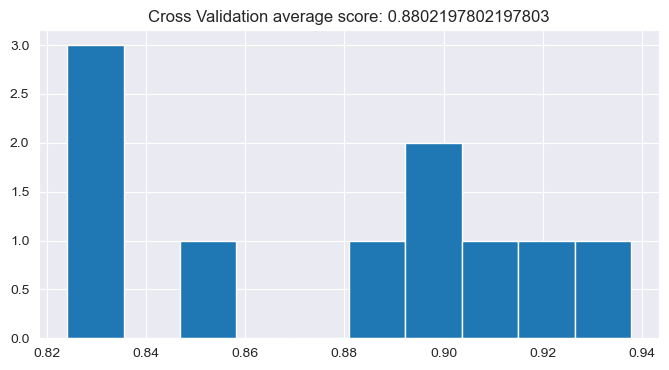

In [37]:
rf_accuracy, rf_precision = average_score(rf_classifier,X,y)
rf_cross = cross_validation(rf_classifier,X,y)
model_scores.append(("Random Forest Classifier",rf_accuracy,rf_precision,rf_cross))

In [38]:
importance(rf_classifier,X_train)

,feature,importance
12,MinorAxisLength,0.076
14,SurfaceArea,0.061
33,GLNonUniformity,0.056
23,DependNonUniformity,0.046
8,DiameterRow,0.043
...,...,...
19,DiffEntropy,0.000
54,ZoneEntropy,0.000
50,SizeZoneNonUniformityNorm,0.000
49,SizeZoneNonUniformity,0.000


### K Neighbors Classifier <a id="Knn"></a>

Testing to see which number of neighbors is the best

In [42]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(np.array(X_test))
score = accuracy_score(y_test, y_pred)
best_score = (1, score)
for i in range(2, 101):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(np.array(X_test))
    score = accuracy_score(y_test, y_pred)
    if score > best_score[1]:  # Compare with the accuracy score, not the tuple
        best_score = (i, score)

print("Best accuracy is " + str(best_score[1]) + " with " + str(best_score[0]) + " neighbors")

Best accuracy is 0.8778998778998779 with 18 neighbors


In [43]:
knn = KNeighborsClassifier(n_neighbors=best_score[0])
knn.fit(X_train, y_train)
y_pred = knn.predict(np.array(X_test))

Accuracy: 0.8778998778998779
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.89      0.88       407
         1.0       0.89      0.87      0.88       412

    accuracy                           0.88       819
   macro avg       0.88      0.88      0.88       819
weighted avg       0.88      0.88      0.88       819


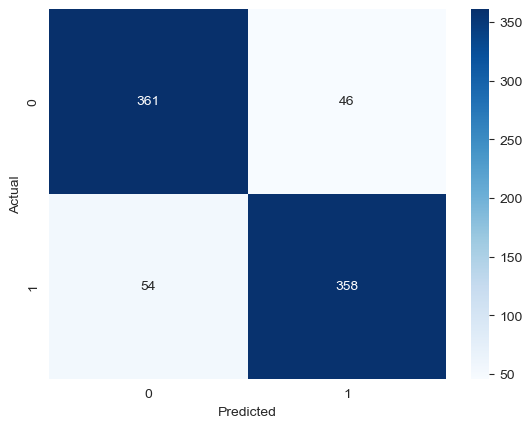

In [44]:
testing(y_test,y_pred)

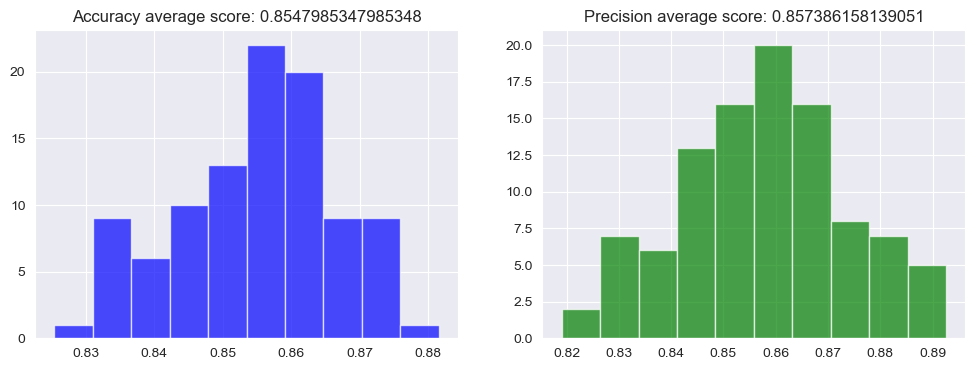

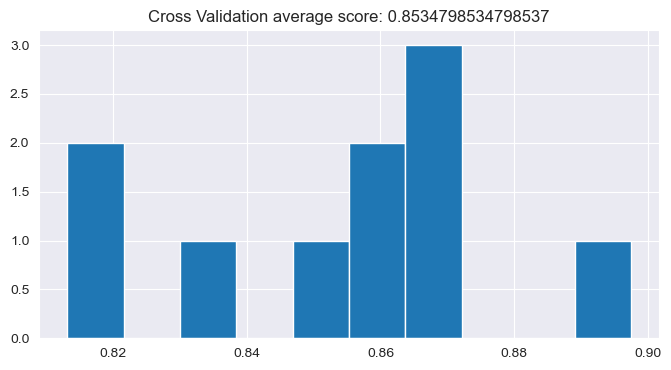

0.8534798534798537

In [45]:
average_score(knn,np.array(X),y)
cross_validation(knn,np.array(X),y)

### Support Vector Machines <a id="Support-Vector-Machines"></a>

In [46]:
svclassifier = SVC(C=10, gamma='scale', kernel='rbf')
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)

Accuracy: 0.8681318681318682
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.91      0.87       407
         1.0       0.90      0.83      0.86       412

    accuracy                           0.87       819
   macro avg       0.87      0.87      0.87       819
weighted avg       0.87      0.87      0.87       819


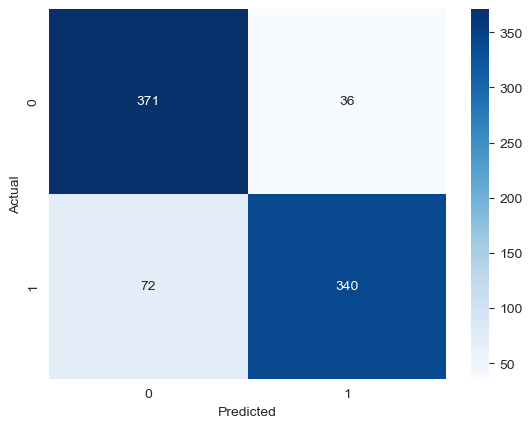

In [47]:
testing(y_test,y_pred)

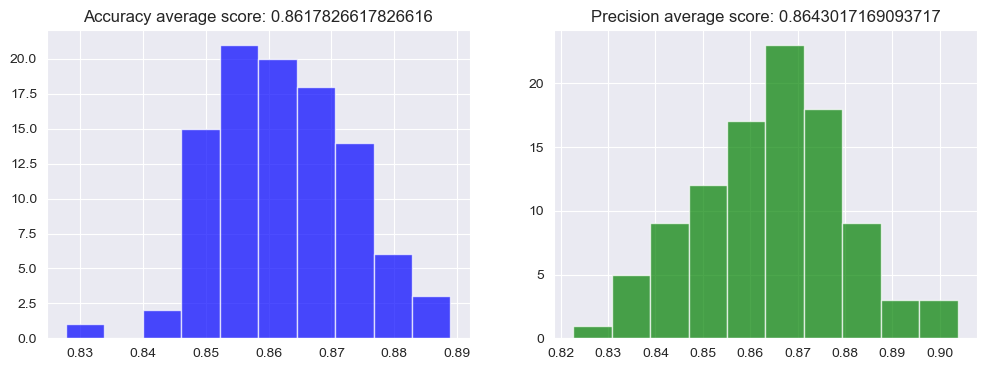

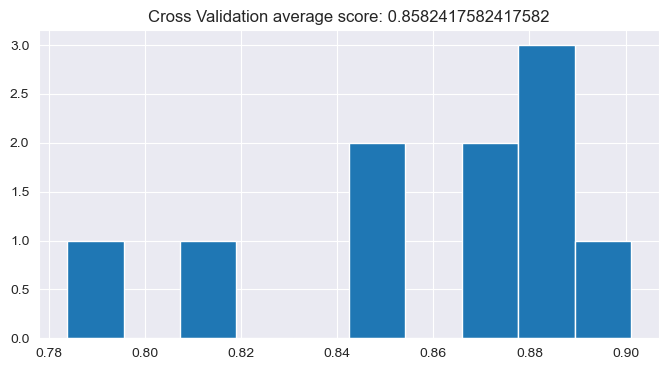

In [48]:
svm_accuracy, svm_precision = average_score(svclassifier,X,y)
svm_cross = cross_validation(svclassifier,X,y)
model_scores.append(("Support Vector Machines",svm_accuracy, svm_precision,svm_cross))

### Naive Bayes <a id="Naive-Bayes"></a>

### GaussianNB <a id="GaussianNB"></a>

In [49]:
gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

Accuracy: 0.7167277167277167
Classification Report:
               precision    recall  f1-score   support

         0.0       0.65      0.95      0.77       407
         1.0       0.91      0.49      0.63       412

    accuracy                           0.72       819
   macro avg       0.78      0.72      0.70       819
weighted avg       0.78      0.72      0.70       819


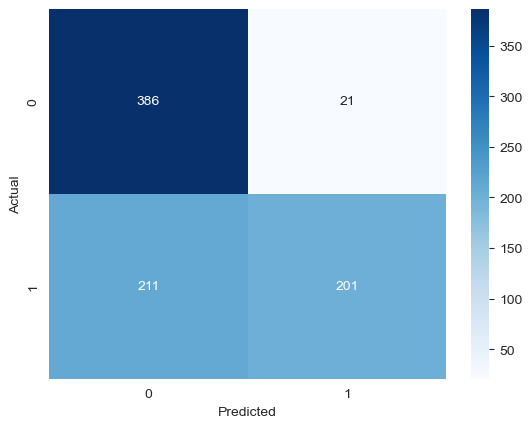

In [50]:
testing(y_test,y_pred)

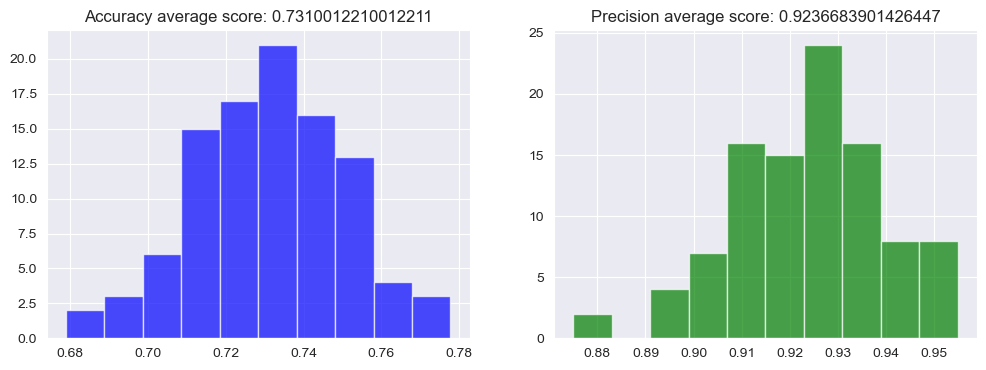

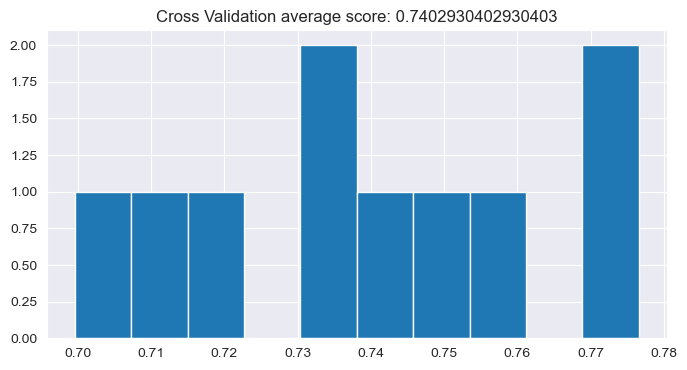

In [51]:
gnb_accuracy, gnb_precision = average_score(gauss,X,y)
gnb_cross = cross_validation(gauss,X,y)
model_scores.append(("Gaussian Naive Bayes",gnb_accuracy, gnb_precision,gnb_cross))

### MultinomialNB <a id="MultinomialNB"></a>

In [52]:
mult = MultinomialNB(alpha=0.5)
mult.fit(X_train, y_train)
y_pred = mult.predict(X_test)

Accuracy: 0.8144078144078144
Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.91      0.83       407
         1.0       0.89      0.72      0.80       412

    accuracy                           0.81       819
   macro avg       0.83      0.81      0.81       819
weighted avg       0.83      0.81      0.81       819


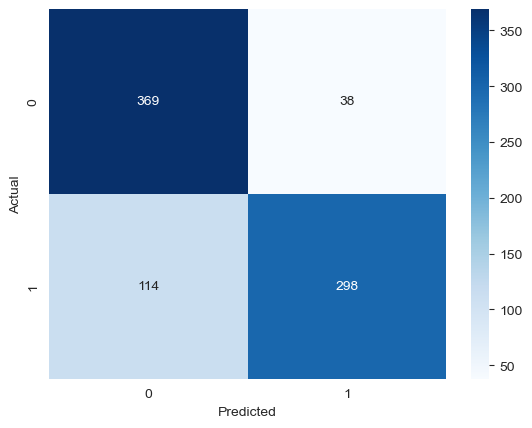

In [53]:
testing(y_test,y_pred)

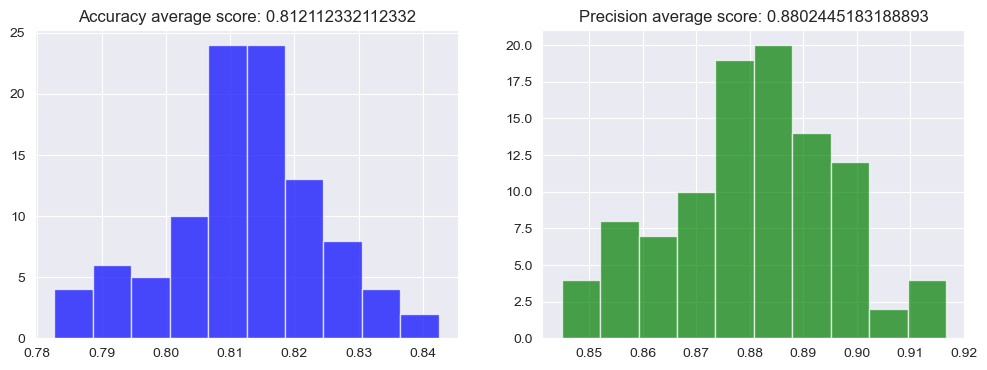

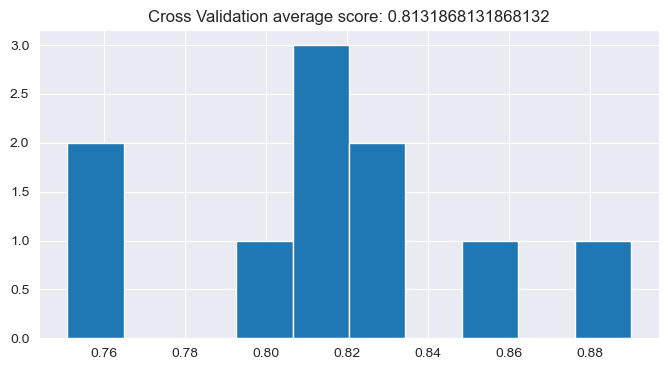

In [54]:
mnb_accuracy, mnb_precision = average_score(mult,X,y)
mnb_cross = cross_validation(mult,X,y)
model_scores.append(("Multinomial Naive Bayes",mnb_accuracy, mnb_precision,mnb_cross))

### Comparing the models

Here we compare all the models test scores:

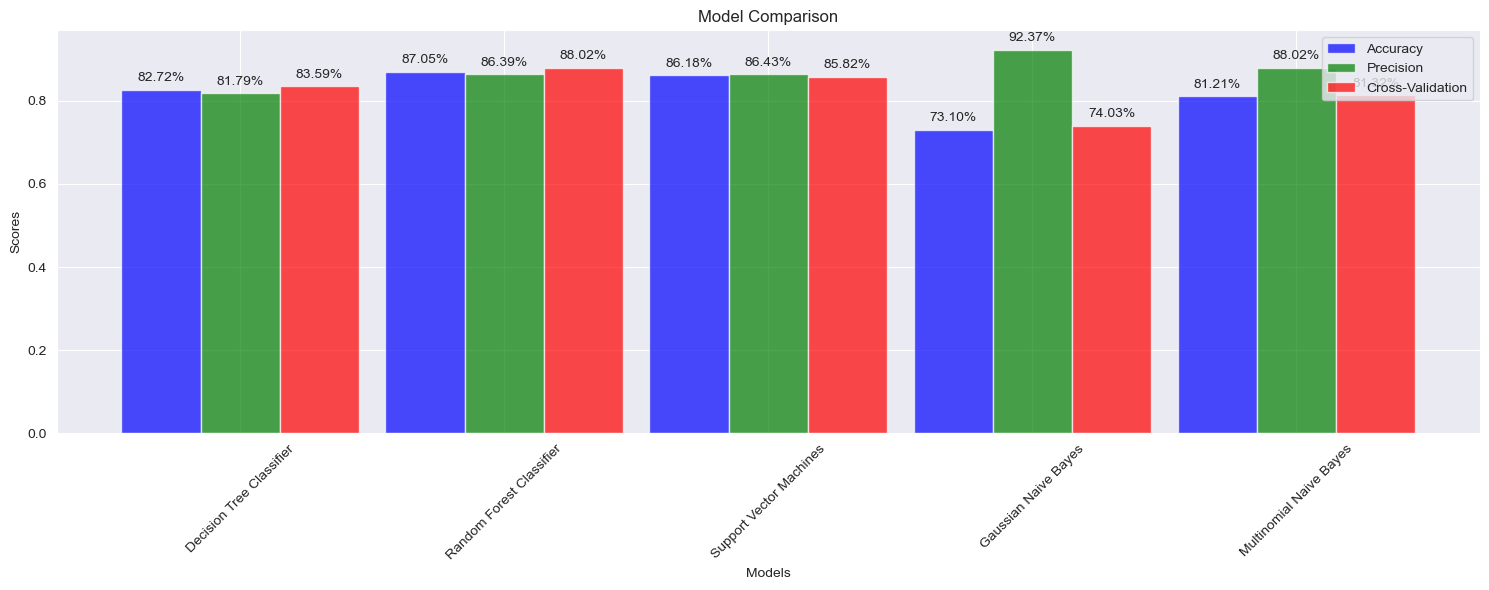

In [55]:
model_names, accuracies, precisions, cross_scores = zip(*model_scores)

x = np.arange(len(model_names))  # X-axis positions

bar_width = 0.3  # Increased bar width
bar_positions = np.arange(len(model_names))

plt.figure(figsize=(15, 6))

plt.bar(bar_positions - bar_width, accuracies, width=bar_width, label='Accuracy', color='b', alpha=0.7)
plt.bar(bar_positions, precisions, width=bar_width, label='Precision', color='g', alpha=0.7)
plt.bar(bar_positions + bar_width, cross_scores, width=bar_width, label='Cross-Validation', color='r', alpha=0.7)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Comparison')
plt.legend()
plt.xticks(bar_positions, model_names, rotation=45)

# Adding text labels for the actual percentages with separation
for i in range(len(model_names)):
    plt.text(bar_positions[i] - bar_width, accuracies[i] + 0.02, f'{accuracies[i]:.2%}', ha='center')
    plt.text(bar_positions[i], precisions[i] + 0.02, f'{precisions[i]:.2%}', ha='center')
    plt.text(bar_positions[i] + bar_width, cross_scores[i] + 0.02, f'{cross_scores[i]:.2%}', ha='center')

plt.tight_layout()
plt.show()

## Parameter Tuning <a id="Parameter-Tuning"></a>

Here are the parameter grids for the models to see which parameters are the best for each model.

In [ ]:
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
param_grid_random_forest = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

For the K Neighbors Classifier we are going to use the best number of neighbors we found before.

In [ ]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

For the Naive Bayes models there are no hyperparameters to tune for Gaussian.

In [ ]:
param_grid_multinomial_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0]
}

In [ ]:
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVC': SVC(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Multinomial Naive Bayes': MultinomialNB()
}

param_grids = {
    'Decision Tree': param_grid_decision_tree,
    'Random Forest': param_grid_random_forest,
    'SVC': param_grid_svc,
    'Multinomial Naive Bayes': param_grid_multinomial_nb
}

In [ ]:
def find_best_model_parameters(classifier, parameters_grid, a, b):
    grid_search = GridSearchCV(estimator=classifier, param_grid=parameters_grid, cv=5, scoring='accuracy')
    grid_search.fit(a, b)

    return grid_search.best_params_, grid_search.best_score_

In [ ]:
best_params_and_scores = {}

for model_name, model in models.items():
    param_grid = param_grids[model_name]

    if not param_grid:
        continue

    best_params, best_score = find_best_model_parameters(model, param_grid, X, y)
    best_params_and_scores[model_name] = {'Best Parameters': best_params, 'Best Score': best_score}

# Print the results
for model_name, result in best_params_and_scores.items():
    print(f'{model_name}:')
    print(f'Best Parameters: {result["Best Parameters"]}')
    print(f'Best Score: {result["Best Score"]}\n')

![img.png](img.png)

We leave here a print of the before of the parameters of the models. The after you can check in the code above:

![before.png](before.png)

## Conclusion <a id="Conclusion"></a>
[Back to index](#Index)

In conclusion, we were able to acquire significant insights into computer vision through feature extraction at the beginning of the project. Subsequently, our knowledge in machine learning was greatly enhanced due to the data preprocessing and algorithm development efforts. As for the results obtained, in our opinion, they were quite satisfactory, as our accuracy, on the whole, consistently remained high. We were also pleased with the feature extraction, as it proved to be the most challenging aspect of the project. Regarding the dataset provided to us, it allowed us to learn extensively due to the necessary data preprocessing and its substantial size.

Overall, we believe that the project was successfully executed, and we achieved our intended objectives. We have a high level of confidence in the results obtained.